# Clustering

Preprocessing and visualization enabled us to align and reduce the dimensionality of our scRNA-seq dataset. However, up to this point cells are still rather abstractly defined through the (normalized) count matrix and the cell covariates. The next natural step in single-cell analysis is the identification of cellular structure in the dataset. 

For this purpose, we structure cells into clusters to infer the identity of similar cells. Clustering itself is a common unsupervised machine learning problem. 
We can derive clusters by minimizing the intra-cluster distance in the reduced expression space. In this case, the expression space determines the gene expression similarity of cells with respect to a dimensionality-reduced representation. This lower dimensional representation is, for example, determined with a principle-component analysis and the similarity scoring is then based on Euclidean distances. 

We propose to use the Leiden algorithm on single-cell KNN graphs to cluster single-cell datasets. The Leiden is a popular community detection method and functions as an improved version of the Louvain algorithm with respect to performance and maintenance of the underlying python package.

The Leiden algorithm is a community detection method that creates clusters by taking into account the number of links between cells in a cluster versus the overall expected number of links in the dataset. The module has a resolution parameter which allows to determine the scale of the partition cluster and therefore the coarseness of the clustering. A higher resolution parameter leads to more clusters. The algorithm additionally allows efficient sub-clustering of particular clusters in the dataset by sub-setting the KNN graph. Subclustering enables the user to identify cell-type specific states within clusters or a finer cell type labeling, but can also lead to patterns that are only due to noise predent in the data.


As mentioned before, the Leiden algorithm is implemented in scanpy.

In [3]:
import scanpy as sc
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80, facecolor='white', frameon=False
)

Firstly, we load our dataset. We perform clustering on the preprocessed sample `site4-donor8` from the NeurIPS human bone marrow dataset which we already used before for quality control, normalization, feature selection and normalization. 

This dataset was normalized with log1pPF, scran and scTransform. We will focus on the scran normalized version of the dataset in this notebook.

In [4]:
adata = sc.read('s4d8_subset_gex.h5ad')

In [3]:
# remove later this functions as sanity check for new annotation
adata.obs['index'] = adata.obs.index + '-s4d8'
adata.obs = adata.obs.set_index('index')

adata_annot = sc.read('openproblems_bmmc_multiome_complete.h5ad')
adata_annot = adata_annot[adata_annot.obs['Site'] == 'site4'].copy()
adata_annot = adata_annot[adata_annot.obs['DonorNumber'] == 'donor8'].copy()
adata_annot = adata_annot[:,adata_annot.var['feature_types'] == 'GEX'].copy()

adata.obs = adata.obs.join(adata_annot.obs[['cell_type']])
# remove later this functions as sanity check for new annotation

As mentioned before, the Leiden algorithm leverages a KNN graph on the reduced expression space. We can calculate the KNN graph on a lower-dimensional gene expression representation with the scanpy function `sc.pp.neighbors`. We call this function on the top 50 principal-components. Additionally, we want to visualize our clustering results. We therefore call `sc.tl.umap` on our AnnData object. More information on UMAP visualizations can be found in the respective chapter.

In [5]:
sc.pp.neighbors(adata, n_pcs=50)
sc.tl.umap(adata)

We can now call the leiden algorithm. The default resolution parameter in scanpy is 1.0. However, in many cases the analyst may want to try different resolution parameters to control the coarseness of the clustering. Hence, we recommend to save the clustering result under a specified key which indicates the selected resolution. This will also help others to reproduce your analysis (more details on reproducibility can be found in the respective chapter). 

In [6]:
sc.tl.leiden(adata, key_added='leiden_res.25', resolution=.25)
sc.tl.leiden(adata, key_added='leiden_res.5', resolution=.5)
sc.tl.leiden(adata, key_added='leiden_res1.', resolution=1.)

We now visualize the different clustering results obtained with the Leiden algorithm at different resolutions. As we can see, the resolution heavily influences how coarse our clustering is. This will become especially important for annotating the clusters. 

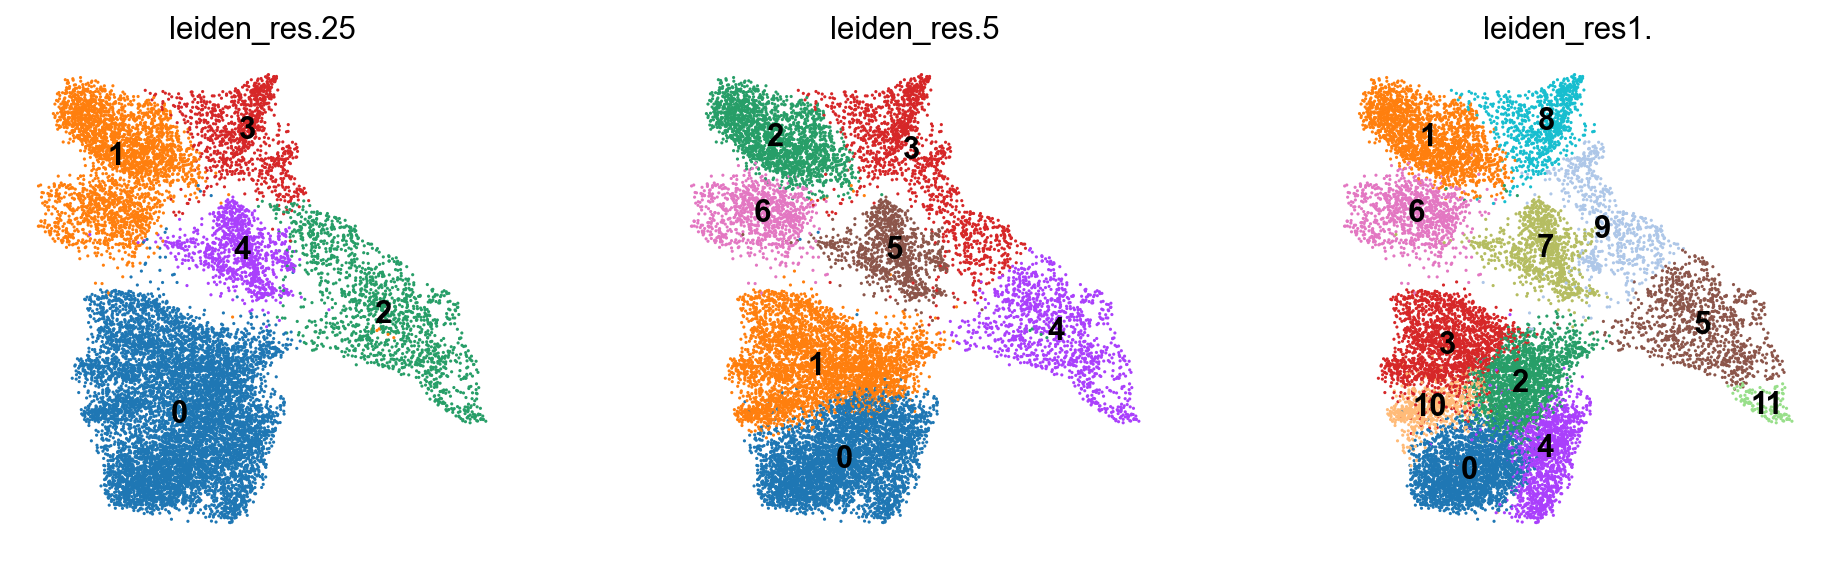

In [7]:
sc.pl.umap(adata, color=['leiden_res.25', 'leiden_res.5', 'leiden_res1.'], legend_loc='on data')


<div class="warning" style='background-color:lightgrey; color: black; border-left: solid back 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:left'>
<b>Main take-away</b></p>
<p style='margin-left:1em;'>
    
- We recommend clustering by Leiden community detection on a single-cell KNN graph.

- Clustering can be performed at different resolutions. Sub-clustering can allow the user to focus on more detailed substructures in the dataset to potentially identify finer cell states. 
</p>
</span>
</div>